## import necessary packages

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch 
import torch.nn as nn
import torch.optim as optim
import cv2
from tqdm.notebook import trange, tqdm
import random
from tqdm.auto import tqdm

import time

import sys, os
BASE = os.getcwd()  
if BASE not in sys.path:
    sys.path.append(BASE)

from funcs import *          
from funcs import utils      
from funcs import proj_cam_model, NetParallelTrain

def setup_seed(seed):
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    random.seed(seed)
    torch.backends.cudnn.deterministic = True
DEVICE = 'cuda'
n_pts = 928
pattern_shape = 768
obj = 'Cup'

## Pattern

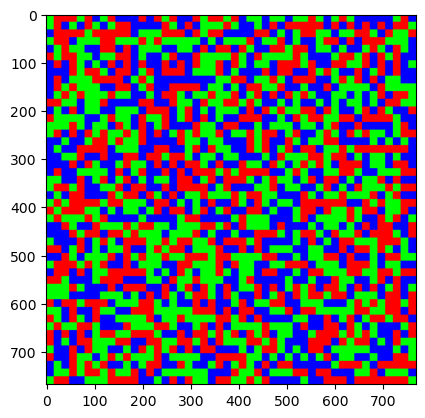

In [2]:
pattern_path = os.path.join("./Patterns/", "rgb_patches_16px.png")

pattern = torch.tensor(
    cv2.imread(pattern_path)[:, :, [2, 1, 0]],
    dtype=torch.float32
).permute(2, 0, 1) / 255.0

plt.imshow(pattern.permute(1,2,0))
plt.show()


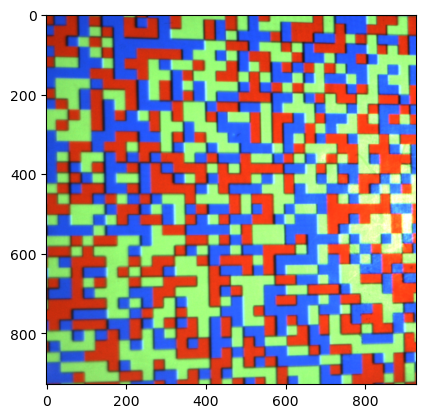

In [3]:
pattern_on_whiteboard_dir = os.path.join("./Real_data/white/", "rgb_patches_16px_projection_00.png")
pattern_on_whiteboard = torch.tensor(
    cv2.imread(pattern_on_whiteboard_dir)[:, :, [2, 1, 0]],
    dtype=torch.float32
).permute(2, 0, 1) / 255.0

plt.imshow(pattern_on_whiteboard.permute(1,2,0))
plt.show()

In [4]:
calib_results = utils.json_loader(file_path=f'./Real_data/{obj}/{obj}_final_calibration_summary.json')
cam_COP = calib_results['camera_position_world']
cam_R = calib_results['R_world_to_camera']
cam_K = calib_results['camera_intrinsic']
proj_COP = calib_results['projector_position_world']
proj_R = calib_results['R_world_to_projector']
proj_K = calib_results['projector_intrinsic']

Projector focal (fx, fy): (2335.5986814028884, 2431.164064277646)
Projector principal point offset (Δx, Δy): (2.381217113307059, 260.9153366032174)
Camera focal (fx, fy): (4521.035459766419, 4526.84027389097)
Camera principal point offset (Δx, Δy): (67.34139750057591, -30.829957684276962)


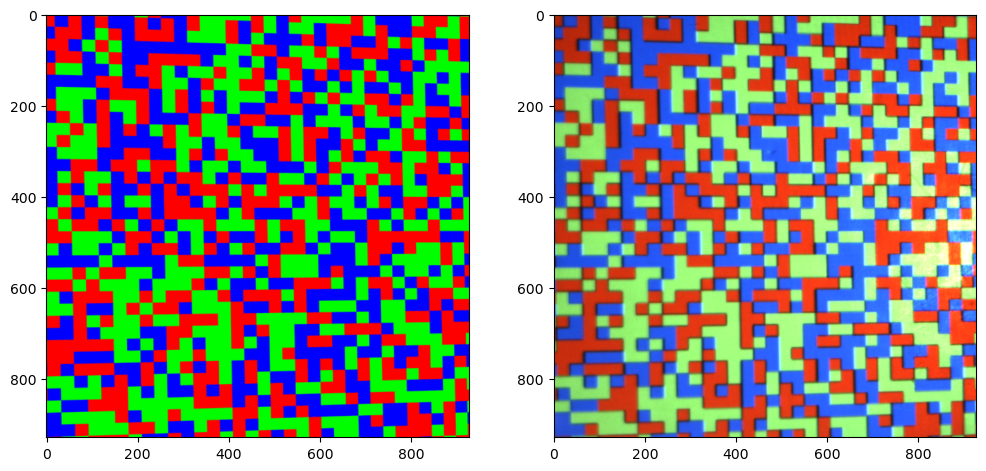

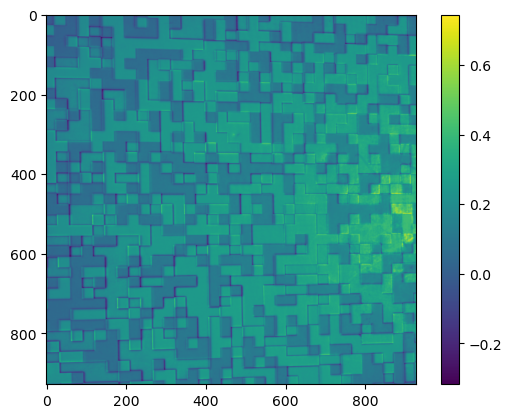

In [5]:
proj_t = -proj_R @ proj_COP
cam_t = -cam_R @ cam_COP


cam_res = (n_pts, n_pts)   
proj_res = (pattern_shape, pattern_shape)  

intrinsics_para = parse_intrinsics(cam_K, proj_K, cam_res, proj_res)

print("Projector focal (fx, fy):", intrinsics_para["projector"]["focal"])
print("Projector principal point offset (Δx, Δy):", intrinsics_para["projector"]["offset"])
print("Camera focal (fx, fy):", intrinsics_para["camera"]["focal"])
print("Camera principal point offset (Δx, Δy):", intrinsics_para["camera"]["offset"])


proj_sensor_size = min(proj_res)
proj_fx, proj_fy = intrinsics_para["projector"]["focal"]   # (fx, fy)
proj_cx_px, proj_cy_px = intrinsics_para["projector"]["offset"]

cam_sensor_size = min(cam_res)
cam_fx,  cam_fy  = intrinsics_para["camera"]["focal"]      # (fx, fy)
cam_cx_px, cam_cy_px = intrinsics_para["camera"]["offset"]
     
    
extent_mm = [-200, 200, -200, 200]   

# Plane coefficients
A = 0.014215
B = 0.008262
C =  0.999865
D = 0.949929

# Extent in mm
xmin, xmax, ymin, ymax = extent_mm

# Resolution
num = proj_res  # 

# Create meshgrid (PyTorch)
x = torch.linspace(xmin, xmax, num[0])
y = torch.linspace(ymin, ymax, num[1])

X, Y = torch.meshgrid(x, y, indexing="xy")  

# Compute Z(x,y)
height_map_whiteboard = -(A * X + B * Y + D) / C

# cam_resolution = 3036
cam_resolution = n_pts
num_photons = None

measured_img = torch.zeros((pattern.shape[0], n_pts, n_pts))[None,:,:,:].to(DEVICE)
reflectance = torch.ones_like(pattern)
for pattern_c in range(pattern.shape[0]):
    pattern_proj = pattern[pattern_c,:,:]
    imager2 = Proj_Cam_model(
        proj_f=(proj_fx, proj_fy),
        cam_f=(cam_fx, cam_fy),

        proj_sensor_w_px=proj_sensor_size,
        proj_sensor_h_px=proj_sensor_size,
        cam_sensor_px=cam_sensor_size,

        proj_R=proj_R, proj_t=proj_t,
        cam_R=cam_R, cam_t=cam_t,

        proj_cx_px=proj_cx_px+0 ,
        proj_cy_px=proj_cy_px ,
        cam_cx_px=cam_cx_px,
        cam_cy_px=cam_cy_px,

        device=DEVICE
    )
    measured_img2 = imager2.render(height_map_whiteboard, reflectance[pattern_c,:,:], pattern_proj,
                                   extent_mm=extent_mm,
                                   photon_count=num_photons, show=0, print_matrix= 0,
                                   cam_res=(cam_resolution, cam_resolution))
    measured_img[0,pattern_c,:,:] = measured_img2.squeeze()

# imager2.plot_geometry(axis_length = 150)
plt.figure(figsize = (12,9))
plt.subplot(121)
plt.imshow(measured_img.squeeze().permute(1,2,0).cpu())
plt.subplot(122)
plt.imshow(pattern_on_whiteboard.permute(1,2,0).cpu())
plt.show()

plt.imshow(torch.abs(rgb_to_gray_tensor(pattern_on_whiteboard).permute(1,2,0).cpu())-rgb_to_gray_tensor(measured_img).squeeze(0).permute(1,2,0).cpu())
plt.colorbar()
plt.show()

In [6]:
# pattern_opt = torch.tensor(np.load('./calibrated_pattern_coeff.npy'))

pattern_opt = torch.zeros_like(pattern).to(DEVICE)
pattern_opt.requires_grad_(True)

optimizer = torch.optim.Adam([pattern_opt], lr=1e-1)

# ----------------------------
# ADD LR SCHEDULER HERE
# ----------------------------
num_iters = 3000
loss_history = []
scheduler = torch.optim.lr_scheduler.StepLR(
    optimizer,
    step_size=1000,   # every step_size iterations
    gamma=0.1        # multiply LR by gamma
)


# ============================================================
# Training loop 
# ============================================================
pbar = tqdm(range(num_iters), desc="Optimizing")
target_optimize = pattern_on_whiteboard[None,:,:,:].to(DEVICE)
for it in pbar:

    optimizer.zero_grad()

    measured_img_pred = torch.zeros_like(measured_img).to(DEVICE)

    # ------------------------------------------------------------
    # Loop over 3 channels (render() only supports 1 channel)
    # ------------------------------------------------------------
    for c in range(3):

        pattern_proj = pattern_opt[c, :, :]
        reflect = reflectance[c, :, :]

        pred_single = imager2.render(
            height_map_whiteboard,
            reflect,
            pattern_proj,
            extent_mm=extent_mm,
            photon_count=None,
            show=0,
            print_matrix=0,
            cam_res=(n_pts, n_pts)
        ).squeeze()

        measured_img_pred[:,c, :, :] = pred_single

    # ------------------------------------------------------------
    # Loss
    # ------------------------------------------------------------
    loss = torch.nn.functional.mse_loss(measured_img_pred, target_optimize)

    loss.backward()
    optimizer.step()
    scheduler.step()  # LR update

    # ------------------------------------------------------------
    # Clamp optimized pattern 
    # ------------------------------------------------------------
    with torch.no_grad():
        pattern_opt.clamp_(0.0, torch.max(pattern_opt))

    # Save loss
    loss_history.append(loss.item())

    # ----------------------------
    # Update tqdm display
    # ----------------------------
    current_lr = scheduler.get_last_lr()[0]
    pbar.set_postfix({
        "loss": f"{loss.item():.6e}",
        "lr": f"{current_lr:.2e}"
    })
    
pattern_opt = pattern_opt.detach()
print("Optimization completed.")
# pattern_opt = pattern_opt/pattern_opt.max()
np.save('./calibrated_pattern_coeff.npy', pattern_opt.detach().cpu().numpy())

Optimizing:   0%|          | 0/3000 [00:00<?, ?it/s]

Optimization completed.


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


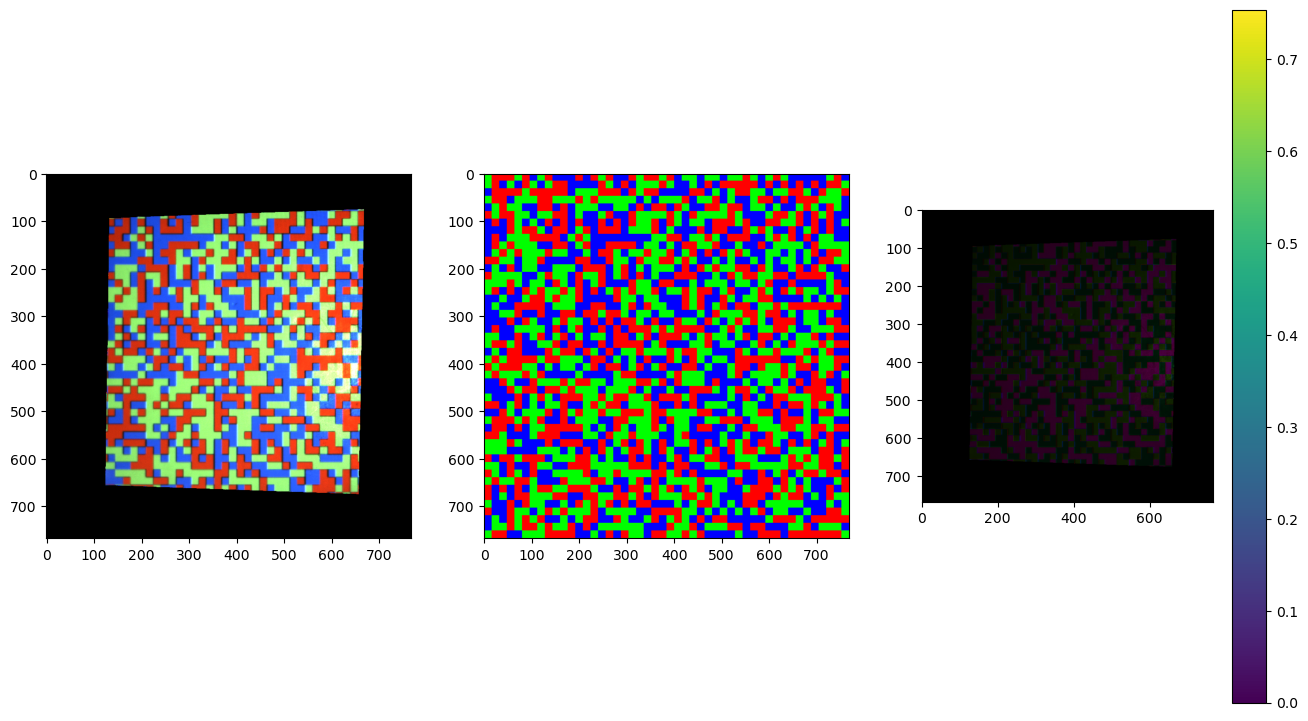

In [7]:
plt.figure(figsize = (16,9))
plt.subplot(131)
plt.imshow(pattern_opt.detach().cpu().permute(1,2,0).numpy())
plt.subplot(132)
plt.imshow(pattern.detach().cpu().permute(1,2,0).numpy())
plt.subplot(133)
plt.imshow(pattern_opt.detach().cpu().permute(1,2,0).numpy()/pattern_opt.detach().cpu().permute(1,2,0).numpy().max() - pattern.detach().cpu().permute(1,2,0).numpy())
plt.colorbar()
plt.show()

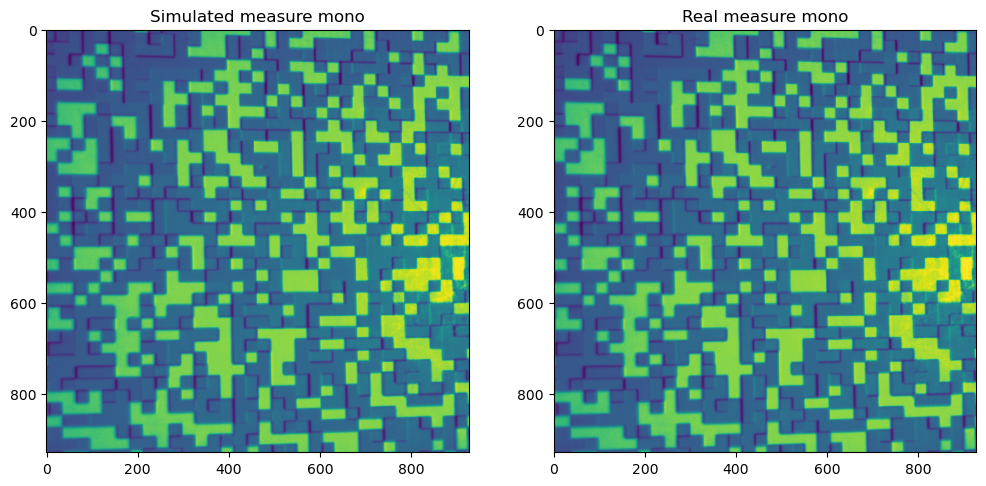

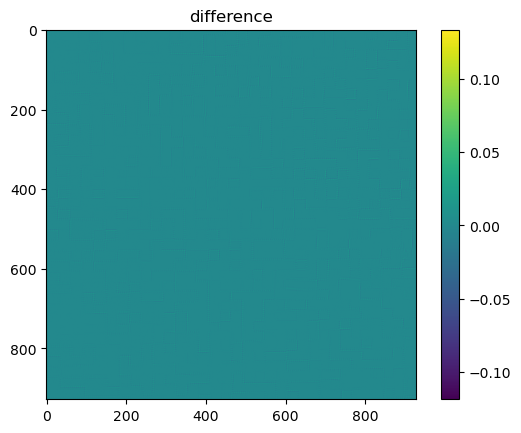

In [8]:
measured_white_img_real = cv2.imread(pattern_on_whiteboard_dir)[:, :, [2, 1, 0]]
measured_white_img_real = measured_white_img_real.astype(np.float32)
measured_white_img_real = measured_white_img_real / (measured_white_img_real.max() + 1e-8)

measured_white_img_real = torch.tensor(
    pad_to_size(
        measured_white_img_real,
        target_size=(n_pts, n_pts),
        pad_dims=(0, 1),
        value=0.0
    ),
    dtype=torch.float32
).permute(2, 0, 1)[None, ...].to(DEVICE)

# gray
measured_white_img_real_mono = (
    rgb_to_gray_tensor(measured_white_img_real)
    .squeeze()
    .detach()
    .cpu()
)

# ========== forward render ==========
measured_white_img_opt = torch.zeros_like(measured_white_img_real)

for c in range(3):
    pattern_proj = pattern_opt[c, :, :]
    reflect = reflectance[c, :, :]

    pred_single = imager2.render(
        height_map_whiteboard,
        reflect,
        pattern_proj,
        extent_mm=extent_mm,
        photon_count=None,
        show=0,
        print_matrix=0,
        cam_res=(n_pts, n_pts)
    ).squeeze()

    measured_white_img_opt[:, c, :, :] = pred_single

# gray
measured_white_img_mono = (
    rgb_to_gray_tensor(measured_white_img_opt.squeeze())
    .squeeze()
    .detach()
    .cpu()
)

# ========== visualization ==========
plt.figure(figsize=(12, 9))

plt.subplot(121)
plt.imshow(measured_white_img_mono.numpy())
plt.title('Simulated measure mono')

plt.subplot(122)
plt.imshow(measured_white_img_real_mono.numpy())
plt.title('Real measure mono')

plt.show()

# ========== difference ==========
I_diff_real = measured_white_img_real_mono - measured_white_img_mono

plt.figure()
plt.imshow(I_diff_real.numpy())
plt.title('difference')
plt.colorbar()
plt.show()


## Network

[1/6399] net0: 5.701e-02


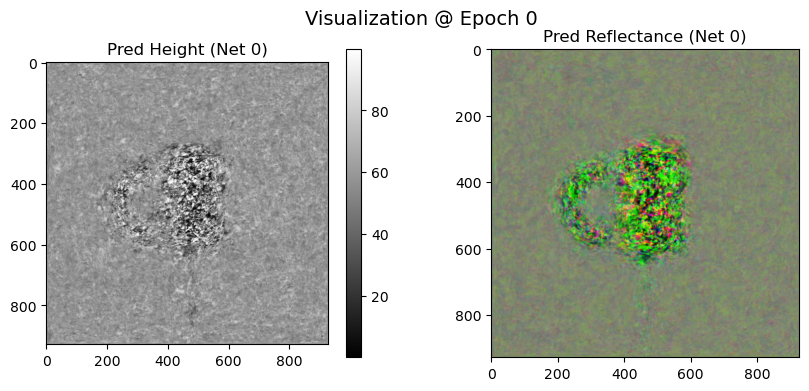

OutOfMemoryError: CUDA out of memory. Tried to allocate 112.00 MiB. GPU 0 has a total capacity of 15.89 GiB of which 65.12 MiB is free. Including non-PyTorch memory, this process has 15.82 GiB memory in use. Of the allocated memory 15.20 GiB is allocated by PyTorch, and 329.60 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

In [9]:
proj_img_sys = imager2


exp_data_folder = f'./Real_data/{obj}/'
pattern_cali = pattern_opt#.to(DEVICE)

output_root = './NN_train_results/' 
os.makedirs(output_root, exist_ok=True)
n_nets = 1

seeds = [42]
for seed in seeds:
    setup_seed(seed)
    measured_img_real = cv2.imread(exp_data_folder + '/rgb_patches_16px_projection_00.png')[:, :, [2, 1, 0]]
    measured_img_real = (measured_img_real / np.max(measured_img_real)) * 1.0
    measured_img_real = torch.tensor(pad_to_size(
        measured_img_real,
        target_size=(n_pts, n_pts),   
        pad_dims=(0, 1),            
        value=0.0
    ), dtype=torch.float32).permute(2,0,1)[None,:,:,:].to(DEVICE)

    # ========== ==========
    model = MultiChannelFusionNet(in_channels=3, base_channels=64).to(DEVICE)

    ParallelTrain = NetParallelTrain(base_model=model, n_nets=1, device=DEVICE)


    multi_model, loss_lists = ParallelTrain.train(
        measured_img=measured_img_real,
        proj_img_sys=proj_img_sys,
        pattern=pattern_cali,
        extent_mm=extent_mm,
        num_epochs=3199*2+1,
        show_every=500,
        use_height_smooth=1,
        use_reflectance_smooth=0,
        msk_on=0,

        snapshot_every=100,
        snapshot_root=f'{output_root}/{seed}/',
    )
